# Understanding Reader Groups with Goodreads Shelves

## Prerequisites

In [128]:
from platform import python_version
print(python_version())

3.6.12


In [1]:
import goodreads_api_client as gr
import pandas as pd
import numpy as np
from datetime import date
import random
import io 
import ast
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.metrics import silhouette_score

random_state = 25

In [2]:
# Request API key: https://www.goodreads.com/api/index
key = 'InsertKeyHere'
client = gr.Client(developer_key=key)

# Reference: https://pypi.org/project/goodreads-api-client/

## Business Understanding

A primary goal of platforms such as Goodreads s to help readers find their next great read. Often book recommendation systems are critiqued for over-recommending popular books and not effectively tailoring recommendations to users unique interests. This analysis seeks to better understand how users describe the books they read, by looking at the virtual "shelves" they create. It will look to see if readers can be clustered by the types of shelves they have, and whether we can derive meaningful reader interest groups based on common shelf patterns.

## Data Understanding

### Create table of Goodreads users and basic stats

In [5]:
# Create a dataframe to store Goodreads user data (id, age, gender, location, year joined, last active)
userdf = pd.DataFrame(columns=['id','age','gender','location','joined','last_active'])

In [4]:
keys = ['id','age','gender','location','joined','last_active']

current_year = date.today().year

In [6]:
# Collect a random sample of user data with the Goodreads API and store in a dataframe
# Function allows you to run the API multiple times over different ranges of user ids,
#  to break up the API calls.

def create_userdf(orig_userdf, id_min, id_max,sample_size):
    '''Returns dataframe of active users
    
    Parameters:
    orig_userdf: Allows you to run this function multiple times to run the API in smaller chunks
    id_min: Specify the minimum user id
    id_max: Specify the maximum user id
    sample_size: Specify the number of users to search with the API
    
    The above parameters allows you to run this function over different ranges of user ids to avoid overlap.
    '''
    userdf_sub = pd.DataFrame(columns=['id','age','gender','location','joined','last_active'])
    
    user_sample = random.sample(range(id_min,id_max), sample_size)
    
    for i in user_sample:
        try:
            user = client.User.show(i)
            user_info = {k:v for k, v in user.items() if k in keys}
            last_act = int(user_info['last_active'][-4:])
        except:
            continue
        else:
            # select users who have been active this year:
            if last_act==current_year:
                df = pd.DataFrame(user_info, index=[0])
                userdf_sub = pd.concat([userdf_sub, df])
    
    new_userdf = pd.concat([orig_userdf, userdf_sub])
    return new_userdf

In [45]:
# Collect sample 1
new_userdf = create_userdf(userdf, 70000000,80000000,20000)
new_userdf.to_csv('new_userdf.csv',index=False)

In [47]:
# Collect sample 2
new_userdf2 = create_userdf(new_userdf, 60000000,69999999,20000)
new_userdf2.to_csv('new_userdf2.csv',index=False)

In [49]:
# Collect sample 3
new_userdf3 = create_userdf(new_userdf2, 50000000,59999999,20000)
new_userdf3.to_csv('new_userdf3.csv',index=False)

In [55]:
# Collect sample 4
new_userdf4 = create_userdf(new_userdf3, 40000000,49999999,20000)
new_userdf4.to_csv('new_userdf4.csv',index=False)

In [57]:
# Collect sample 5
new_userdf5 = create_userdf(new_userdf4, 30000000,39999999,20000)
new_userdf5.to_csv('new_userdf5.csv',index=False)

In [243]:
# Collect sample 6
new_userdf6 = create_userdf(new_userdf5, 20000000,29999999,20000)
new_userdf6.to_csv('new_userdf6.csv',index=False)

### Create table of users' shelves

Up until now we've just collected basic demographic info on the users. Now we want to collect data on their shelves.

In [39]:
shelf6 = pd.read_csv('new_userdf6.csv')
user_list6 = shelf6.id.unique().tolist()

In [ ]:
shelf_df6b = pd.DataFrame(columns=['user_id','shelf_name'])

# The first three shelves are "read", "to-read", and "currently-reading". 
# We're not going to collect those because we're only interested in the genre-related shelves.
shelf_num = range(3,100)

# For each user, collect their shelf names and sizes (number of books per shelf) to store in a dataframe
for i in user_list6:
    user = client.User.show(i)
    for j in shelf_num:
        try:
            shelf_name = user.get('user_shelves',{}).get('user_shelf',{})[j].get('name')
            shelf_size = user.get('user_shelves',{}).get('user_shelf',{})[j].get('book_count',{}).get('#text')
        except:
            break
        else:
            if shelf_name not in exclude_shelves:
                df2 = pd.DataFrame({'user_id':user['id'], 'shelf_name':shelf_name, 'shelf_size':shelf_size}, index=[0]) 
                shelf_df6b = shelf_df6b.append(df2)

In [ ]:
# If API times out, pick up where you left off:
processed_users6 = shelf_df6.user_id.unique().tolist()
remaining_users6 = np.setdiff1d(user_list6,processed_users6)

In [263]:
for i in remaining_users6: 
    user = client.User.show(i)
    for j in shelf_num: 
        try:
            shelf_name = user.get('user_shelves',{}).get('user_shelf',{})[j].get('name')
            shelf_size = user.get('user_shelves',{}).get('user_shelf',{})[j].get('book_count',{}).get('#text')
        except:
            break
        else:
            df2 = pd.DataFrame({'user_id':user['id'], 'shelf_name':shelf_name, 'shelf_size':shelf_size}, index=[0]) 
            shelf_df6b = shelf_df6b.append(df2)

In [265]:
# Store shelf dataframe for easy access
shelf_df.to_csv('shelf_df6b.csv',index=False)

## Data Preparation

### Checkpoint: Load user and shelf dataframes

In [3]:
shelf_df = pd.read_csv('final_shelfdf.csv')
final_userdf = pd.read_csv('final_userdf.csv')

In [4]:
# Format age, year joined, and shelf size as integers for analysis
final_userdf['age'] = pd.to_numeric(final_userdf['age'], errors='coerce')
final_userdf['year_joined'] = final_userdf['joined'].str[-4:].astype(int)

In [5]:
shelf_df['shelf_size'] = shelf_df['shelf_size'].astype(int)

### Prep Step 1: Remove shelves that don't add information

In [6]:
shelves = shelf_df.copy()

# 1. Remove empty shelves
shelves = shelves.query('shelf_size > 0')

# 2. Remove shelves that don't describe the contents of the book
exclude_words = ['201','202','4','read','want','buy','next','own','bought','wish','tbr','interested','shelved','shelf','coming-soon',
                'book','library','purchased','hold','on-loan','unhaul',
                'have','borrow','dnf','finish','gave-up','abandon','started','dropped','pause','maybe','meh','second-chance',
                 'favorite','favourite','-star','recommend','favorito','favs','faves',
                 'review','arc','net-galley','netgalley','signed','default',
                 'kindle','paperback','hardcover','pdf','audible','audio','listened','digital','hoopla','storytel','overdrive'
                ]

shelves = shelves[~shelves.shelf_name.str.contains('|'.join(exclude_words))]

# 3. Because users read different amounts of books, create a column to show the relative proportion of books 
#   from a single shelf per user
shelves['percent_of_books'] = round(((shelves['shelf_size']/shelves.groupby('user_id')['shelf_size'].transform('sum'))*100),2)

# 4. Remove users with a single shelf of 1 or 2 books
exclude_users_df = shelves[(shelves['shelf_size'] < 100) & (shelves['percent_of_books'] == 100.0)]
exclude_users = exclude_users_df['user_id'].tolist()
select_shelves = shelves[~shelves['user_id'].isin(exclude_users)]

# 5. Remove users' least used shelves

select_shelves = select_shelves.query('percent_of_books >=1')

# 6. Unify naming conventions
num_users = pd.DataFrame(select_shelves.groupby('shelf_name')['user_id'].nunique())

# 7. Identify shelf names that are only used by a single user
not_rare = pd.DataFrame(num_users.query('user_id>1')).reset_index()
rare_shelves = pd.DataFrame(num_users.query('user_id==1')).reset_index()
rare_list = rare_shelves['shelf_name'].tolist()

In [136]:
# Data understanding: Rare shelf count and percent
print(rare_shelves['shelf_name'].count())
print(round(rare_shelves['shelf_name'].count()/(rare_shelves['shelf_name'].count()+not_rare['shelf_name'].count())*100),4)

3352
87 4


In [7]:
# Create a dictionary to map any rare spellings with more common spellings
file = io.open('shelf_dictionary.txt', 'r', encoding='utf-8')
contents = file.read()
shelf_map = ast.literal_eval(contents)
file.close()

In [8]:
mapped_shelves = select_shelves.copy()
mapped_shelves = mapped_shelves.replace({'shelf_name':shelf_map})

In [9]:
# Reassess mapping:
num_users2 = pd.DataFrame(mapped_shelves.groupby('shelf_name')['user_id'].nunique()).reset_index()

not_rare2 = pd.DataFrame(num_users2.query('user_id>1'))
rare_shelves2 = pd.DataFrame(num_users2.query('user_id==1'))
sort_of_rare = pd.DataFrame(num_users2.query('user_id==2'))

In [10]:
not_rare2.to_csv('shelf_cleaning.csv',index=False)

In [11]:
# 8. Replace shelves only used by a single user with "other"
num_users2 = num_users2.rename(columns={'user_id':'num_users'})

clean_shelves = mapped_shelves.merge(num_users2, how='left', left_on='shelf_name', 
                                     right_on='shelf_name')

clean_shelves = clean_shelves.copy()
clean_shelves['shelf_name'][clean_shelves.num_users == 1] = 'other'

clean_shelves = clean_shelves[clean_shelves.shelf_name != 'other']

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
num_shelves = pd.DataFrame(clean_shelves['user_id'].value_counts()).reset_index()
num_shelves.rename(columns={'index':'user_id','user_id':'num_shelves'},inplace=True)

clean_shelves = clean_shelves.merge(num_shelves, left_on='user_id',right_on='user_id',how='left')

# See how many unique users remain after cleaning
clean_shelves.user_id.nunique()

730

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


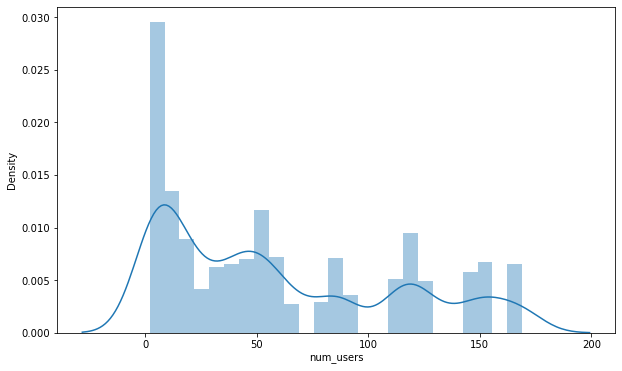

In [13]:
# Examine popularity of each shelf
fig, ax = plt.subplots(figsize = (10, 6))
sns.distplot(clean_shelves.num_users, bins=25)
plt.show()

We can see the shelves are skewed - a lot more shelves have less than 50 users. We'll explore setting a minimum number of users per shelf for the cluster analysis to ensure the data aren't too sparse.

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


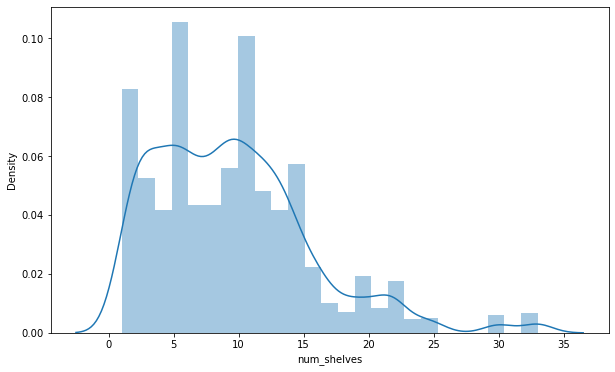

In [14]:
# Examine distribution of number of shelves per user
fig, ax = plt.subplots(figsize = (10, 6))
sns.distplot(clean_shelves.num_shelves, bins=25)
plt.show()

We can see most users have less than 15 shelves.

In [157]:
# Specify minimum popularity of shelves included
min_users = 50
# Lower thresholds of users were tried as well, but did not have a noticeable impact on the cluster analysis.

num_users2 = num_users2.rename(columns={'user_id':'num_users'})
top_shelves = pd.DataFrame(num_users2.query('num_users>=@min_users'))


select_feats = clean_shelves.merge(top_shelves, how='inner', 
                                    left_on='shelf_name', 
                                    right_on='shelf_name')

### Prep Step 2: Combine user info and shelf info

In [158]:
final_df = select_feats.merge(final_userdf, left_on='user_id', right_on='id', how='left')

final_df = final_df.drop(columns=['id','joined','last_active'])

In [159]:
# Create dataframe for cluster analysis
select_cols = final_df[['user_id','shelf_name','percent_of_books']]

pivot = pd.pivot_table(select_cols, 
                       index='user_id', 
                       columns='shelf_name', values='percent_of_books', aggfunc=np.mean,
                      fill_value=0).reset_index()

pivoted_df = pd.DataFrame(pivot).drop(columns=['user_id'])

# Save copy with user_id for user profile analysis
profiles_df = pd.DataFrame(pivot)

### Address skewed data

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


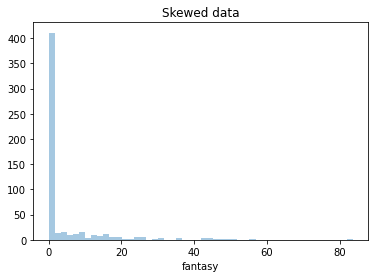

In [160]:
sns.distplot(pivoted_df['fantasy'], hist=True, kde=False)
plt.title('Skewed data')
plt.show()

In [161]:
feats_log = pivoted_df.apply(lambda x: np.log(x+1))

In [162]:
final_feats = feats_log.copy()

## Modeling

### PCA

Two approaches to the cluster analysis were tested:
- Manual reduction of shelves by setting a threshold of minimum number of users per shelf
- Principal Component Analysis

Neither approach yeilded high performance on the cluster analysis.

In [166]:
n_comp = .95 # explains 95% of variance
pca = PCA(n_components=n_comp)
pca.fit(final_feats)
final_feats_pca = pca.transform(final_feats)

In [167]:
pca_df = pd.DataFrame(np.round(pca.components_, 3), 
                          columns = final_feats.columns)

In [205]:
comp = pca_df.T

def notable_feats(comp_num):
    '''Returns visual of top 3 positive and negative features within a given component
    
    Parameter: comp_num: Input component number from PCA
    '''
    sorted_comp = comp[comp_num].sort_values()
    
    fig, ax = plt.subplots(figsize = (10,4))
    pos = sorted_comp.copy()
    neg = sorted_comp.copy()
    pos[pos <= 0] = np.nan
    neg[neg > 0] = np.nan
    
    pos.iloc[np.r_[0:3, -3:0]].plot(ax = ax, kind = 'bar', color=['crimson'])
    neg.iloc[np.r_[0:3, -3:0]].plot(ax = ax, kind = 'bar', color=['royalblue'])
    plt.title('Component %i' %(comp_num))
    plt.xlabel('Shelf')
    plt.show()
    print(pd.DataFrame(sorted_comp.head(3)))
    print(pd.DataFrame(sorted_comp.tail(3)))
    
# References: 
#  Udacity course material from the Intro to Machine Learning Nanodegree
#  https://stackoverflow.com/questions/31345489/pyplot-change-color-of-line-if-data-is-less-than-zero

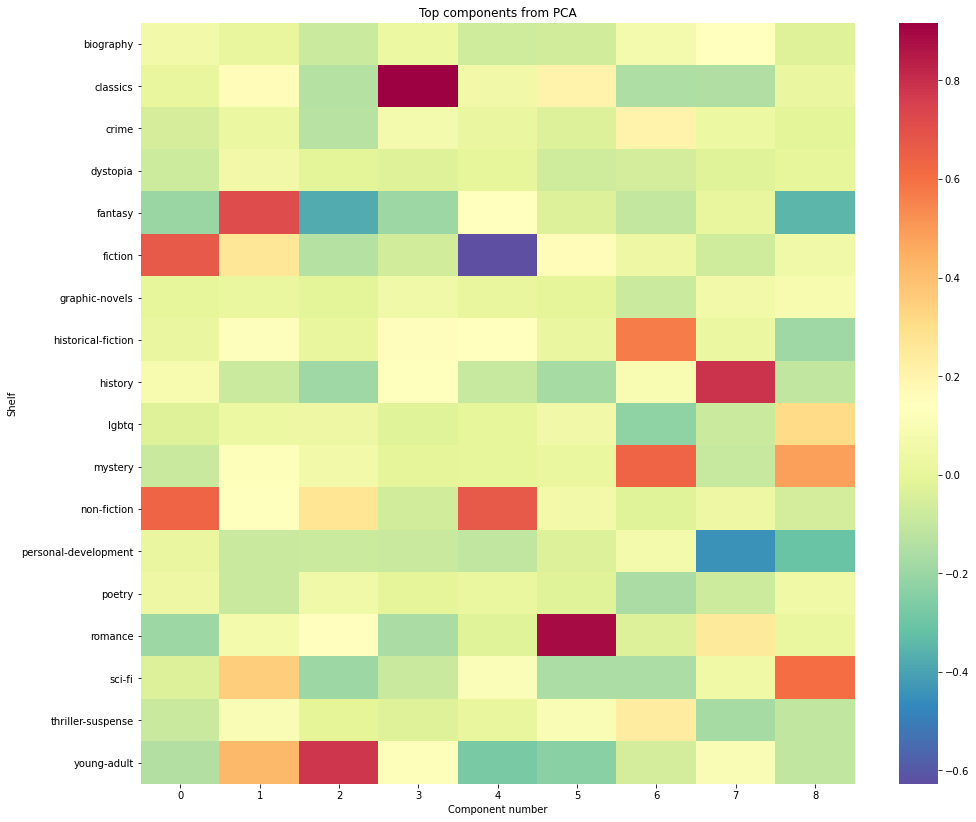

In [223]:
fig, ax = plt.subplots(figsize = (16, 14))
ax = sns.heatmap(comp.iloc[:,:9], cmap='Spectral_r')
plt.title('Top components from PCA')
plt.xlabel('Component number')
plt.ylabel('Shelf')
plt.show()

Lets take a look at a few components. 6 and 8 are interesting because they both feature "mystery" in their top three but are otherwise very different.

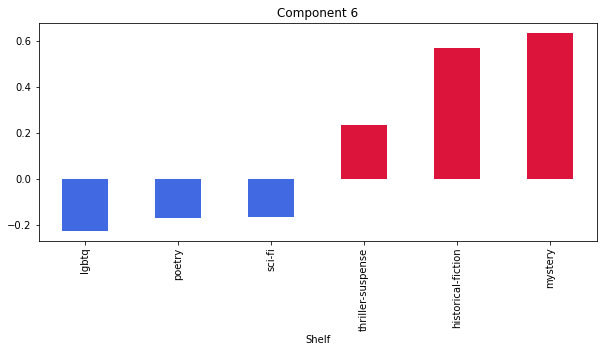

                6
shelf_name       
lgbtq      -0.223
poetry     -0.167
sci-fi     -0.162
                        6
shelf_name               
thriller-suspense   0.235
historical-fiction  0.569
mystery             0.636


In [208]:
notable_feats(6)

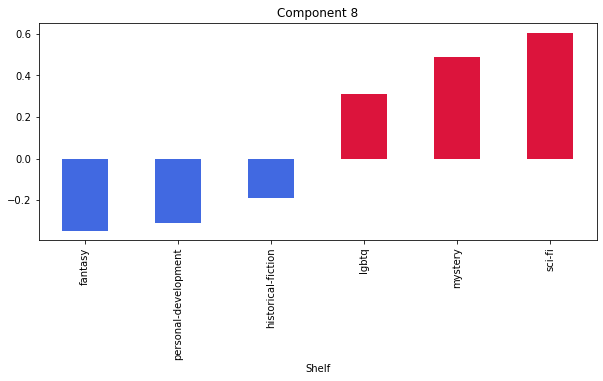

                          8
shelf_name                 
fantasy              -0.346
personal-development -0.310
historical-fiction   -0.189
                8
shelf_name       
lgbtq       0.308
mystery     0.488
sci-fi      0.604


In [207]:
notable_feats(8)

## Cluster Analyses and Evaluation

Several cluster techniques were attempted over a range of cluster sizes, with and without PCA. All yeilded low silhouette scores.

### K-means

In [209]:
n_clusters=20

In [210]:
# K-means without PCA
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans_fit = kmeans.fit(final_feats)
kmeans_pred = kmeans_fit.predict(final_feats)

kmeans_sscore = silhouette_score(final_feats, kmeans_pred)
kmeans_sscore

0.18116307436813042

In [41]:
# K-means with PCA
kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans_fit = kmeans.fit(final_feats_pca)
kmeans_pred_pca = kmeans_fit.predict(final_feats_pca)

kmeans_sscore_pca = silhouette_score(final_feats_pca, kmeans_pred_pca)
kmeans_sscore_pca

0.20245714464981102

Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

### Hierarchical

In [42]:
# Ward Clustering without PCA
ward = AgglomerativeClustering(n_clusters=n_clusters)
ward_pred = ward.fit_predict(final_feats)

ward_sscore = silhouette_score(final_feats, ward_pred)
ward_sscore

0.15797130974842355

In [43]:
# Ward Clustering with PCA
ward = AgglomerativeClustering(n_clusters=n_clusters)
ward_pred_pca = ward.fit_predict(final_feats_pca)

ward_sscore = silhouette_score(final_feats_pca, ward_pred_pca)
ward_sscore

0.17365498310740718

In [214]:
# Average linkage clustering without PCA
avg = AgglomerativeClustering(n_clusters=n_clusters, 
                              linkage = 'average')
avg_pred = avg.fit_predict(final_feats)

avg_sscore = silhouette_score(final_feats, avg_pred)
avg_sscore

0.1057608818813198

### Proportion of sample in each cluster

In [138]:
sample_counts = pd.Series(kmeans_pred_pca).value_counts().sort_index()

sample_idx = sample_counts.index.values

proportion_df = pd.DataFrame(data=sample_counts, index=sample_idx, columns=['Count'])

proportion_df['Cluster'] = proportion_df.index

proportion_df['Proportion'] = round((proportion_df['Count']/proportion_df['Count'].sum())*100,1)

proportion_df.sort_values('Proportion', ascending=False)

# Reference: Udacity course material from the Intro to Machine Learning Nanodegree

,Count,Cluster,Proportion
1,62,1,11.1
5,47,5,8.4
6,41,6,7.4
3,39,3,7.0
10,38,10,6.8
0,35,0,6.3
13,34,13,6.1
2,31,2,5.6
4,25,4,4.5
18,24,18,4.3


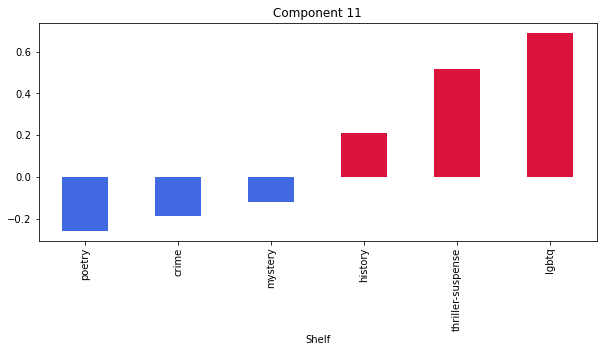

               11
shelf_name       
poetry     -0.256
crime      -0.188
mystery    -0.120
                      11
shelf_name              
history            0.209
thriller-suspense  0.518
lgbtq              0.689


In [215]:
notable_feats(11)

### Conclusion

The Goodreads user shelf data is sparse and higlighy variable. There is potential generating more accurate reader profiles with more complete and standardized data.

### Appendix: Additional descriptive data on users

Below are a few quick summaries of our user and shelf data. We can see shelves differe by age and geography.

In [52]:
user_profiles = profiles_df.merge(final_userdf, how='left', left_on='user_id', 
                                     right_on='id')

In [54]:
user_profiles[['age','year_joined']].describe()

,age,year_joined
count,150.000000,557.000000
mean,32.080000,2015.127469
std,12.115507,1.567400
min,19.000000,2013.000000
25%,24.250000,2014.000000
50%,28.000000,2015.000000
75%,35.750000,2016.000000
max,100.000000,2018.000000


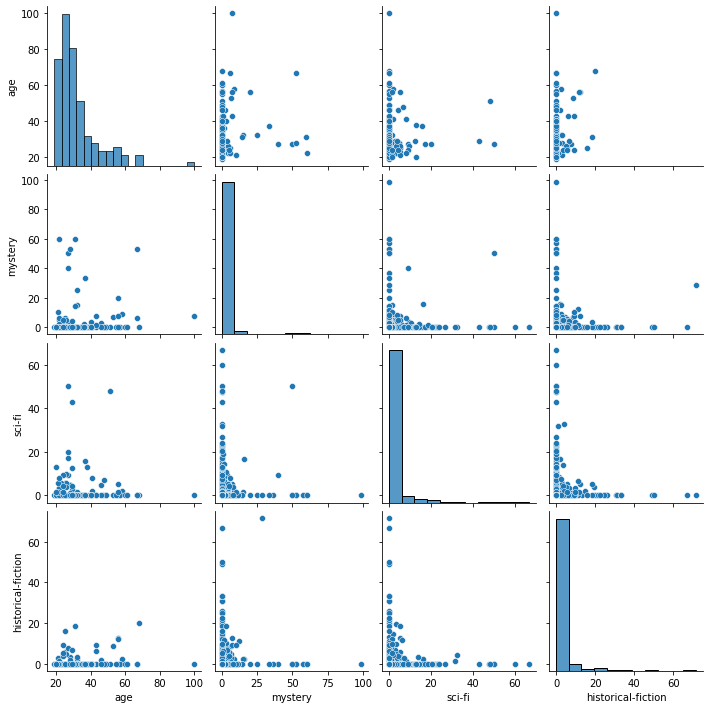

In [58]:
sns.pairplot(user_profiles[['age','mystery','sci-fi','historical-fiction']])

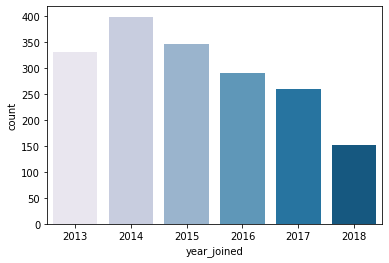

In [44]:
ax = sns.countplot(data=final_df, x='year_joined', palette='PuBu')

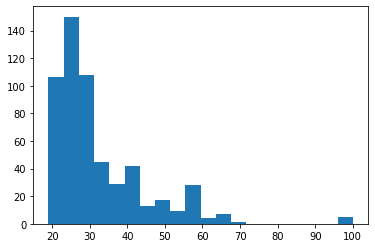

In [45]:
ages = final_df['age'].dropna()
# Here we're just dropping nulls to look at the actual ages of users who provided their age. 
# If we were to use age in the actual model, we would impute the missing values so as to not 
#   lose all of those records for analysis. 

plt.hist(ages, bins=20)
plt.show()

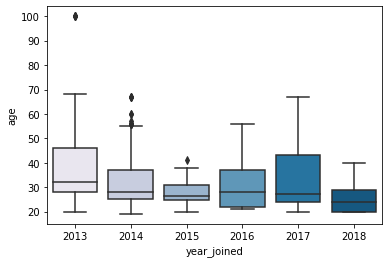

In [46]:
ax = sns.boxplot(data=final_df, x='year_joined', y='age', palette='PuBu')

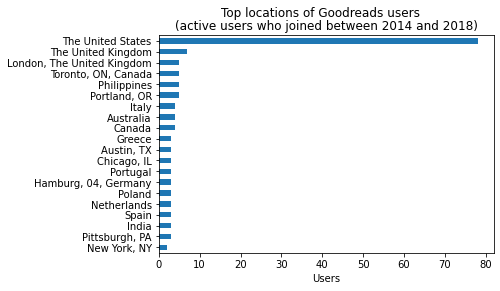

In [78]:
user_profiles.location.value_counts().sort_values(ascending=False).head(20).plot(kind='barh').invert_yaxis()

plt.suptitle('Top locations of Goodreads users')
plt.title('(active users who joined between 2014 and 2018)')
plt.xlabel('Users')

plt.show()

In [218]:
sel_locs = user_profiles[user_profiles['location'].isin(['Italy','Australia','Greece','Portugal', 'India'])]

<AxesSubplot:xlabel='location', ylabel='mystery'>

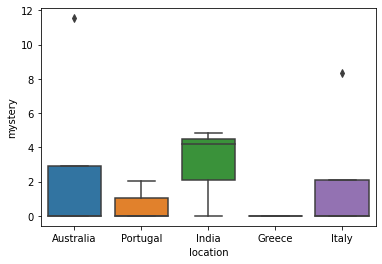

In [219]:
sns.boxplot(data=sel_locs, y='mystery', x='location')

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


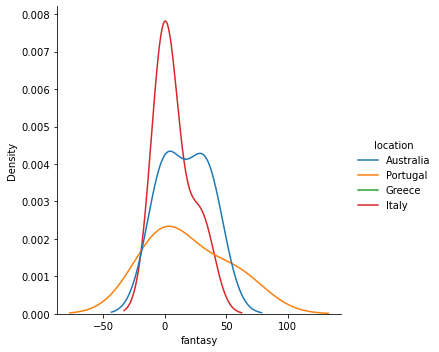

In [102]:
sns.displot(sel_locs, x='fantasy', hue='location', kind='kde')

C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


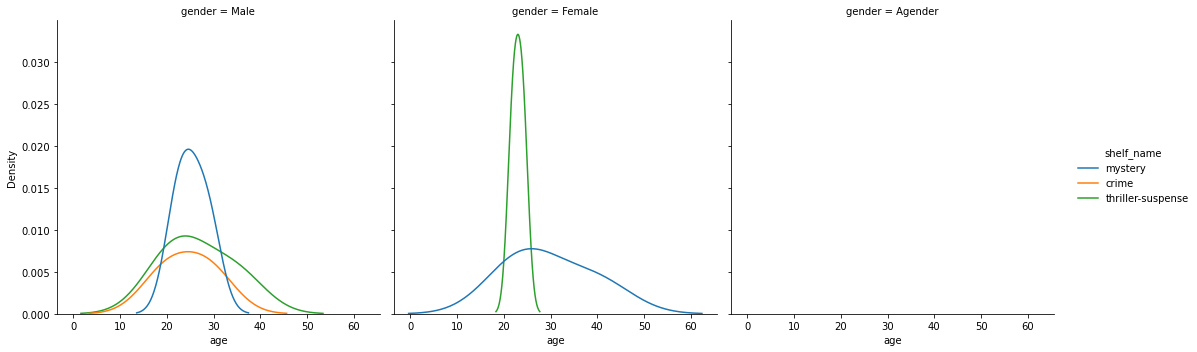

In [64]:
shelf_comp1 = final_df[final_df['shelf_name'].isin(['crime','mystery','thriller-suspense'])]

sns.displot(shelf_comp1, 
             x='age', hue='shelf_name', kind='kde', col='gender')

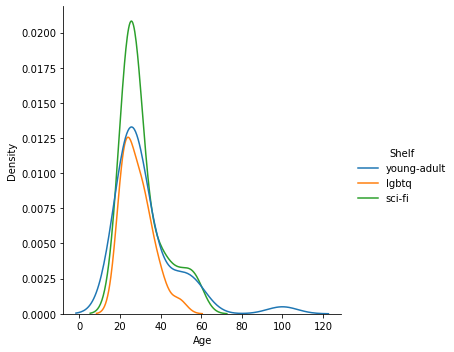

In [95]:
shelf_comp1 = final_df[final_df['shelf_name'].isin(['sci-fi',
                                                    'young-adult','lgbtq'])]

ax = sns.displot(shelf_comp1, 
             x='age', hue='shelf_name', kind='kde')
ax.set(xlabel='Age')
ax._legend.set_title('Shelf')

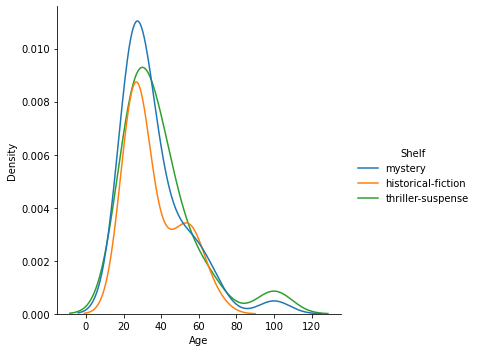

In [96]:
shelf_comp2 = final_df[final_df['shelf_name'].isin(['mystery','thriller-suspense',
                                                    'historical-fiction'])]

ax = sns.displot(shelf_comp2, 
             x='age', hue='shelf_name', kind='kde')
ax.set(xlabel='Age')
ax._legend.set_title('Shelf')

[Text(0, 0.5, 'Shelf')]

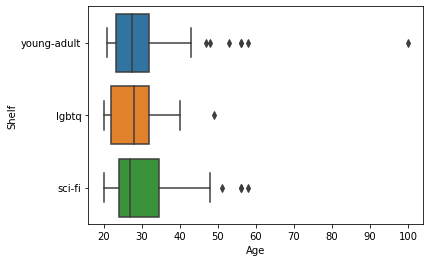

In [97]:
ax = sns.boxplot(data=shelf_comp1, x='age', y='shelf_name')
ax.set(xlabel='Age')
ax.set(ylabel='Shelf')

[Text(0, 0.5, 'Shelf')]

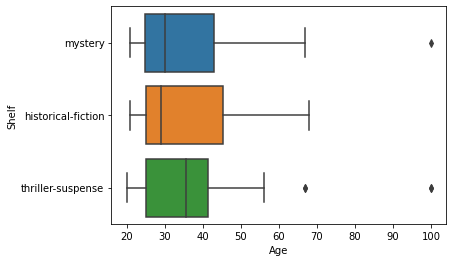

In [98]:
ax = sns.boxplot(data=shelf_comp2, x='age', y='shelf_name')
ax.set(xlabel='Age')
ax.set(ylabel='Shelf')

In [91]:
user_profiles_sub = user_profiles[['young-adult','lgbtq','sci-fi','mystery','thriller-suspense',
                                                    'historical-fiction']]
user_profiles_sub.describe()

,young-adult,lgbtq,sci-fi,mystery,thriller-suspense,historical-fiction
count,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000
mean,4.186688,1.536146,2.125958,1.978079,1.524556,1.736840
std,12.361192,7.875019,7.141680,8.466036,7.453481,6.690352
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,100.000000,66.670000,98.550000,75.000000,71.430000


In [102]:
user_profiles.query('age>90')

,user_id,biography,classics,crime,dystopia,fantasy,fiction,graphic-novels,historical-fiction,history,...,sci-fi,thriller-suspense,young-adult,id,age,gender,location,joined,last_active,year_joined
36,22736372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.9,6.43,22736372,100.0,NaN,"Philadelphia, PA",08/2013,08/2020,2013


C:\Users\Admin\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


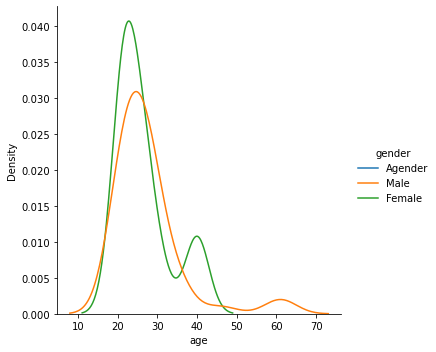

In [76]:
sns.displot(final_df, x='age', hue='gender', kind='kde')

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


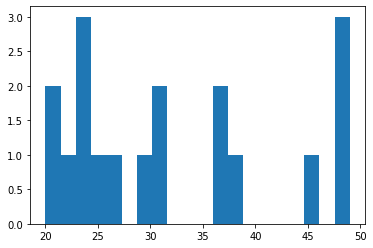

In [50]:
crime_ages = final_df.query('shelf_name=="crime"')['age']
plt.hist(crime_ages, bins=20)
plt.show()

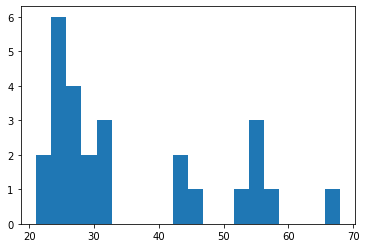

In [101]:
historical_ages = final_df.query('shelf_name=="historical-fiction"')['age']
plt.hist(historical_ages, bins=20)
plt.show()